In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
# Read data from file 'spx.csv'
data = pd.read_csv('spx.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [3]:
# We just want to focus on data after crisis, which is approximately after 1/1/2009
data = data['20090101':]
data.tail()

,close
date,
2018-06-25,2717.07
2018-06-26,2723.06
2018-06-27,2699.63
2018-06-28,2716.31
2018-06-29,2718.37


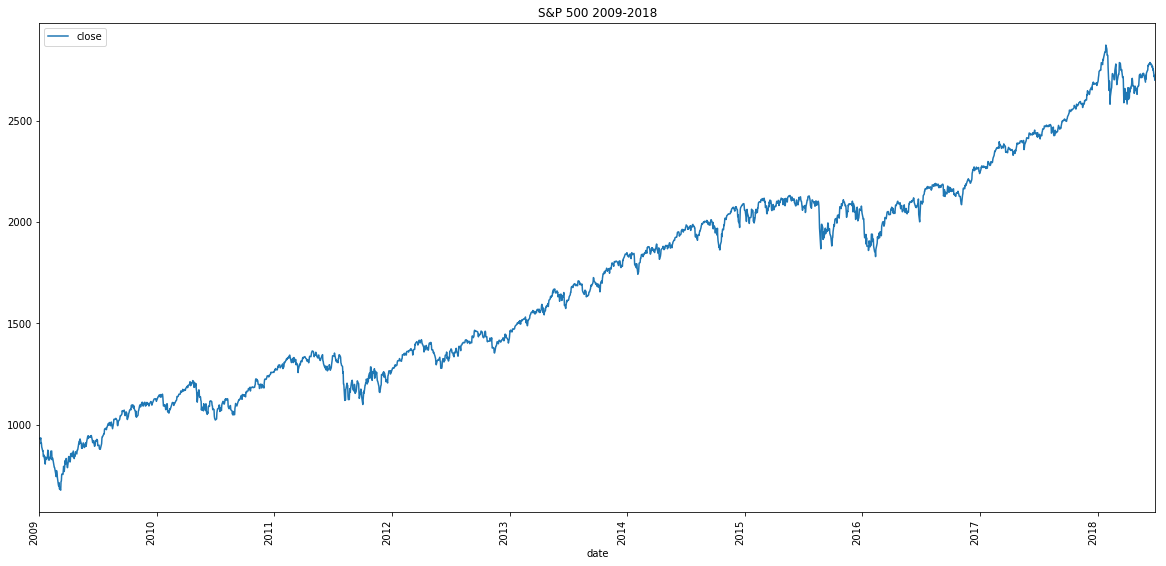

In [4]:
data.plot(title='S&P 500 2009-2018', kind='line', y='close')
plt.xticks(rotation=90)
plt.gcf().set_size_inches(20, 10)

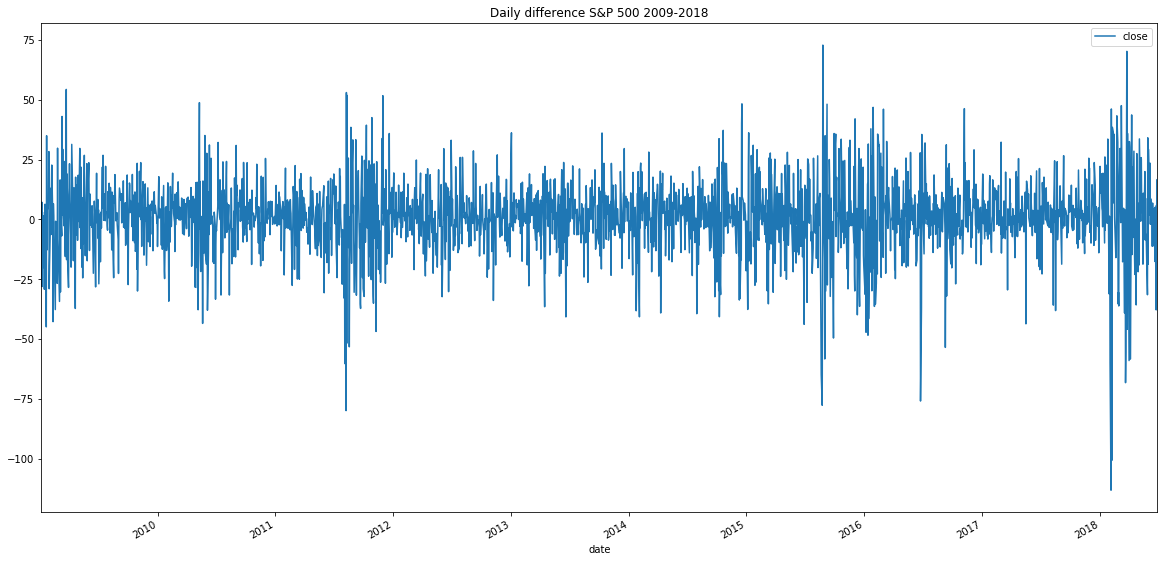

In [5]:
# It seems like a non-stationary upward trending time series
# Let's take a look at daily difference of this time series
diff1 = data.diff()
diff1.dropna(inplace=True)
diff1.plot(title='Daily difference S&P 500 2009-2018', kind='line', y='close')
plt.gcf().set_size_inches(20, 10)

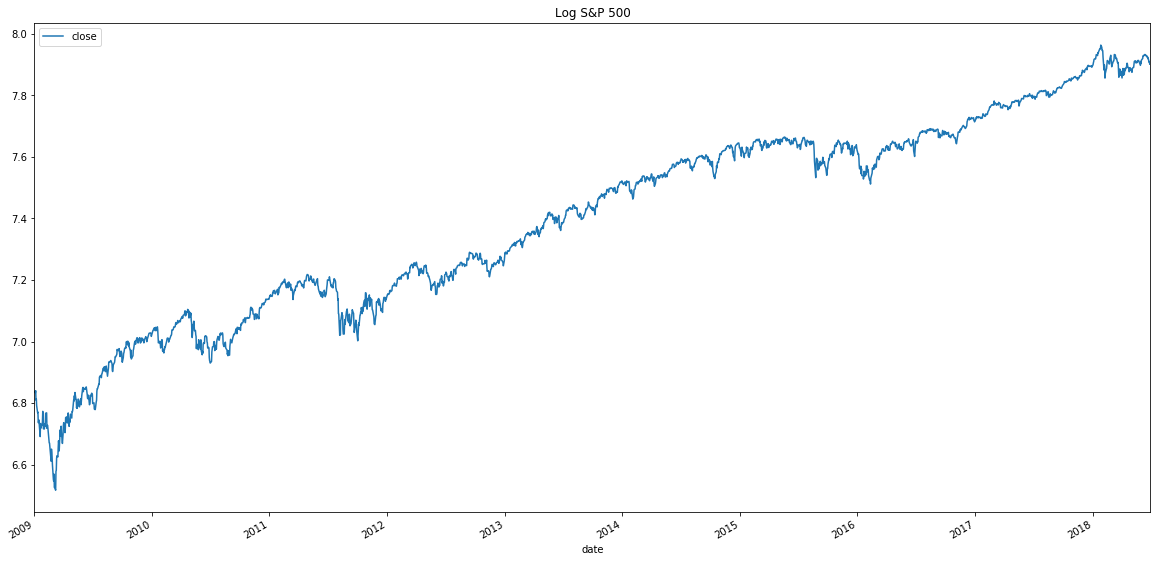

In [7]:
# Let's take a log and see how it will change
data_log = np.log(data)
data_log.plot(title='Log S&P 500')
plt.gcf().set_size_inches(20, 10)

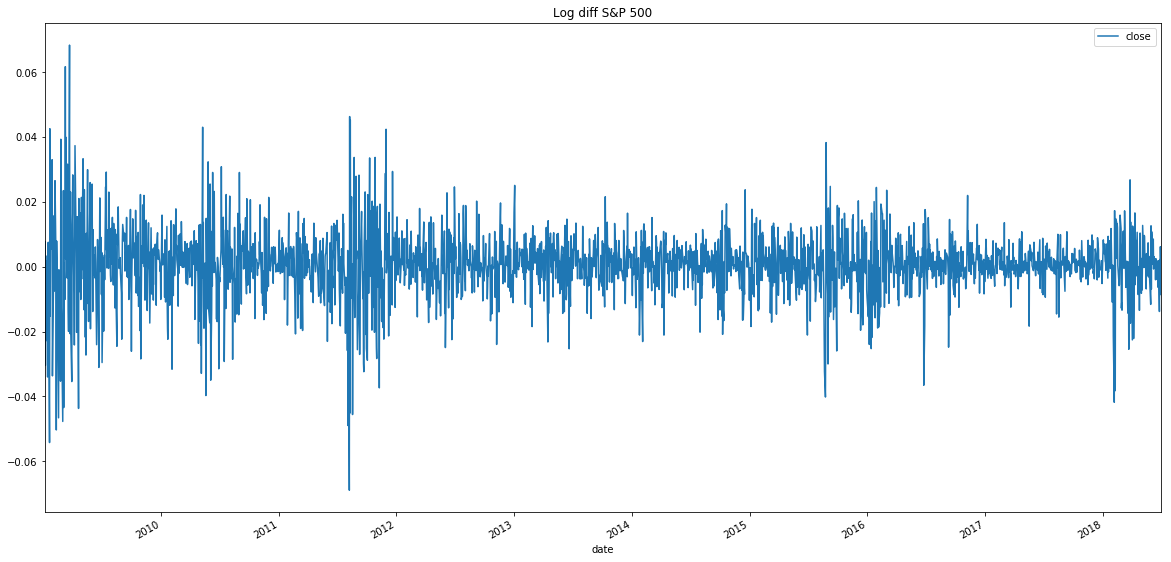

In [8]:
diff1_log = data_log.diff()
diff1_log.dropna(inplace=True)
diff1_log.plot(title='Log diff S&P 500')
plt.gcf().set_size_inches(20, 10)

In [9]:
# Let's take a Augmented Dickey-Fuller test on both diff time series to see if the null hypothesis can be rejected
for df in [diff1, diff1_log]:
    adf_test = sm.tsa.stattools.adfuller(df['close'])
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -23.563548
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -10.960497
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We observed both ADF stats is smaller than 1% critical values, which means we can reject the null hypothesis at 99% confidence level that it has unit root. So they are both stationary process. Let's focus on diff1 for now.

In [10]:
# In order to use ARIMA method to predict this stationary time series, we need to determined p, q and d parameters
# We first plot ACF and PACF to see if it can give us estimate on p and q
diff_acf = sm.tsa.stattools.acf(diff1, nlags=20)
diff_pacf = sm.tsa.stattools.pacf(diff1, nlags=20, method='ols')

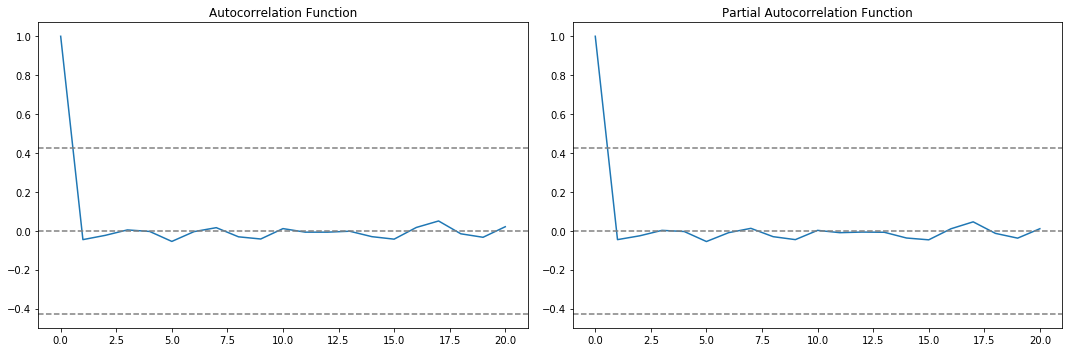

In [11]:
# Plot ACF and PACF
plt.subplot(121)
plt.plot(diff_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_acf)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(diff_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_acf)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.gcf().set_size_inches(15, 5)
plt.tight_layout()

p--the lag value where the PACF chart crosses the upper confidence interval for the first time, in this case p = 1
q--the lag value where the ACF chart crosses the upper confidence interval for the first time, in this case q = 1
This is also intuitive in financial market: the most relevant previous number to today number D(t) is D(t-1)

C:\Python\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


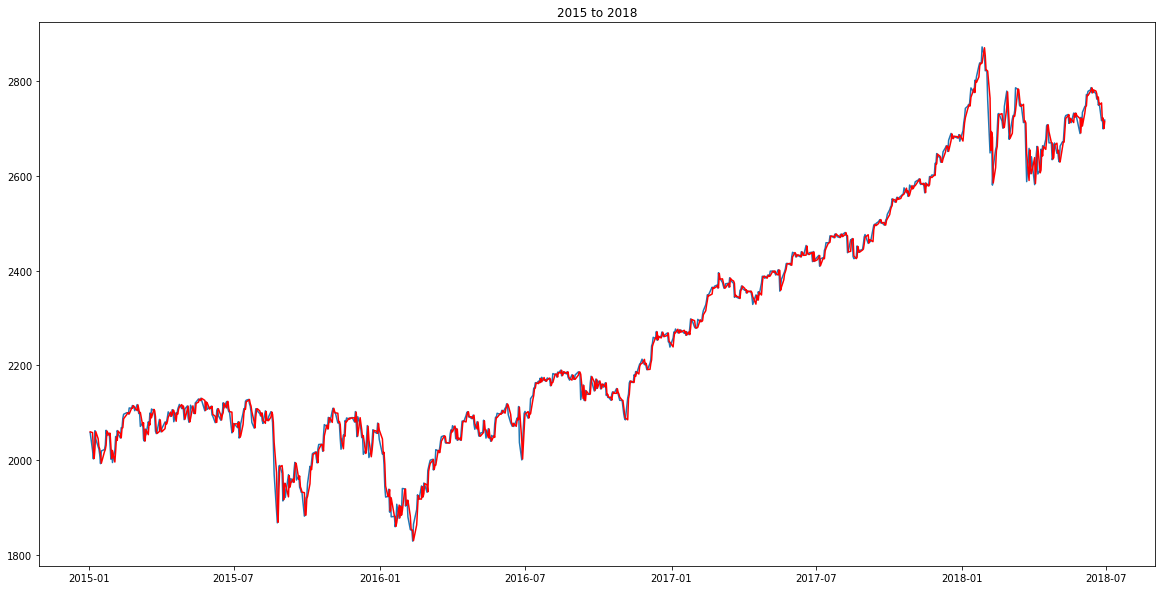

In [52]:
# Fit the ARIMA model
model1 = sm.tsa.ARIMA(data, order=(1,0,1))
model_fit1 = model1.fit(disp=0)

# Let's look at how this model is doing by looking at data since early 2015
data1 = data['20150101':]
fitted_value1 = model_fit1.fittedvalues['20150101':]

plt.plot(data1)
plt.plot(fitted_value1, color='red')
plt.title('2015 to 2018')
plt.gcf().set_size_inches(20, 10)

In [53]:
model_fit1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 19930.3078
Dependent Variable: close            Log-Likelihood:      -9949.6   
Date:               2019-06-11 23:11 Scale:               1.0000    
No. Observations:   2390             Method:              css-mle   
Df Model:           3                Sample:              0         
Df Residuals:       2387                                  0         
Converged:          1.0000           S.D. of innovations: 15.524    
No. Iterations:     7.0000           HQIC:                19915.603 
AIC:                19907.1916                                      
--------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|   [0.025    0.975] 
--------------------------------------------------------------------
const         1712.6259 751.7367    2.2782 0.0228 239.2491 3186.0028
ar.L1.close      0.9998   0.0002 4516.2058 0.0000   0.9994    1.0003
ma.L1.close     -0.0451   0.0209   -2.1585 0.0310  -0.0860   -0.0041
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0002             0.0000           1.0002             0.0000
MA.1           22.1922             0.0000          22.1922             0.0000
====================================================================

"""

C:\Python\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 19908.5650
Dependent Variable: D.close          Log-Likelihood:      -9938.7   
Date:               2019-06-11 23:21 Scale:               1.0000    
No. Observations:   2388             Method:              css-mle   
Df Model:           3                Sample:              1         
Df Residuals:       2385                                  9         
Converged:          1.0000           S.D. of innovations: 15.508    
No. Iterations:     46.0000          HQIC:                19893.863 
AIC:                19885.4521                                      
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           0.0002    0.0004     0.5368  0.5915  -0.0006   0.0011
ar.L1.D.close  -0.0453    0.0204    -2.2183  0.0266  -0.0854  -0.0053
ma.L1.D.close  -1.0000    0.0011  -921.6570  0.0000  -1.0021  -0.9978
-----------------------------------------------------------------------------
                Real            Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1          -22.0522             0.0000          22.0522             0.5000
MA.1            1.0000             0.0000           1.0000             0.0000
====================================================================

"""

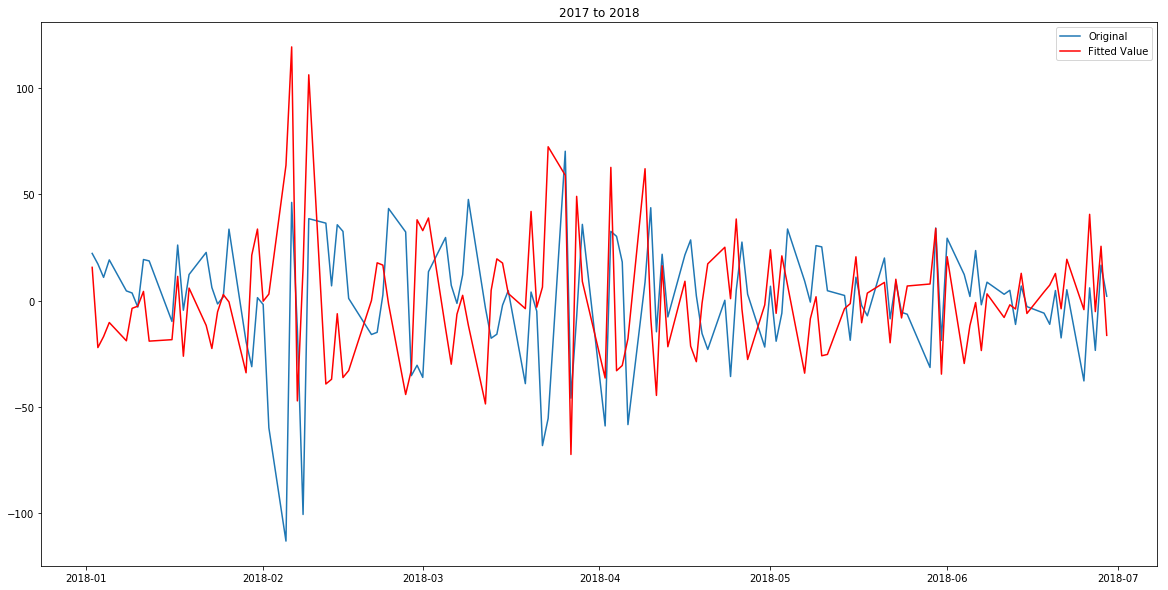

In [71]:
# let's fit a second ARIMA model on the daily difference
model2 = sm.tsa.ARIMA(diff1, order=(1,1,1))
model_fit2 = model2.fit(disp=0)

# Let's look at how this model_fit2 is doing by looking at data since early 2015
diff1_1 = diff1['20180101':]
fitted_value2 = model_fit2.fittedvalues['20180101':]

plt.plot(diff1_1, label='Original')
plt.plot(fitted_value2, color='red', label='Fitted Value')
plt.title('2017 to 2018')
plt.legend()
plt.gcf().set_size_inches(20, 10)

model_fit2.summary2()

In [75]:
# Define a function to revert a difference back to original states

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [79]:
# Load the test data and take the next 7 days data as test set
test = pd.read_csv('test.csv')
test['Date'] = pd.to_datetime(test['Date'])
test = test.set_index('Date')
test = test[['Close']][:7]
test

,Close
Date,
2018-07-02,2726.709961
2018-07-03,2713.219971
2018-07-05,2736.610107
2018-07-06,2759.820068
2018-07-09,2784.169922
2018-07-10,2793.840088
2018-07-11,2774.020020


In [80]:
forecast1 = model_fit.forecast(steps=7)[0]

diff_forecast = model_fit2.forecast(steps=7)[0]
forecast2 = []
hist = [2718.37]
for d in diff_forecast:
    f_next = inverse_difference(hist, d, 1)
    forecast2.append(f_next)
    hist.append(f_next)
    
test['Forecast1'] = pd.Series(forecast1, index=test.index)
test['Forecast2'] = pd.Series(forecast2, index=test.index)
test

,Close,Forecast1,Forecast2
Date,,,
2018-07-02,2726.709961,2718.069859,2719.352987
2018-07-03,2713.219971,2717.902227,2720.385060
2018-07-05,2736.610107,2717.734622,2721.415155
2018-07-06,2759.820068,2717.567046,2722.445586
2018-07-09,2784.169922,2717.399497,2723.476249
2018-07-10,2793.840088,2717.231977,2724.507148
2018-07-11,2774.020020,2717.064484,2725.538284


Seems like both ARIMA models didn't do a good job on out of sample forecasting